# Notes

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions 

In [3]:
def return_state_probabilities_from_state_tseries(state_tseries, numLabelledStates):
    ''' Return the probabilities of each state in the state_tseries. 
        Each value in state_tseries is between 0 and numLabelledStates-1, or NaN,
        or -1 if it was belonging to another cluster (nonlabelled cluster)
        Return the probability of each state as a vector, with the last entry being prob
        of another cluster, and NaN data excluded.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from -1,  
                   Can contains NaNs.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    state_probs: 1D array of shape (numLabelledStates+1,), containing the probability of 
                 each cluster idx and lastly the probability of nonlabelled clusters
    '''
    # add one state for -1 (nonlabelled cluster)
    numStates = numLabelledStates + 1
    # preallocate the output
    state_probs = np.zeros((numStates,))
    #  find the number of frames in total excluding NaN frames
    state_tseries_nanless = state_tseries[~np.isnan(state_tseries)]
    numFrames = state_tseries_nanless.shape[0]
    # if we have no non-nan frames, all probs are zero except the last
    if numFrames == 0:
        return state_probs
    else:
        # first compute main states probs
        for stateIdx in range(numLabelledStates):
            state_counts = np.where(state_tseries_nanless==stateIdx)[0].shape[0]
            state_probs[stateIdx] = state_counts / numFrames
        # now add the final NaN probability
        other_state_counts = np.where(state_tseries_nanless==-1)[0].shape[0]
        state_probs[-1] = other_state_counts / numFrames
        return state_probs


    
def compute_state_probabilities_in_time_windows(state_tseries, time_windows, numLabelledStates):
    ''' Compute the probability of each of the state indices in state_tseries, in
        each of the windows in time_windows.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from 0 to (numLabelledClusters-1)
                   for the labelled states, -1 for all nonlabelled states, and NaN for missing data.
    time_windows: array of shape (numWins,2), where each row contains a start frame
                  and a stop frame which define a region in time. The probabilities
                  are estimated in each of these regions in time.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    window_state_probabilities: a (numWinds, numLabelledStates+1) array containing the 
                                probability of each cluster idx and lastly the probability of 
                                nonlabelled cluster occuring. 
                                
    --- see also ---
    return_state_probabilities_from_state_tseries: 
    the function which does the main computation in each time window.
    
    '''
    numWins = time_windows.shape[0]
    window_state_probabilities = np.zeros((numWins, numLabelledStates+1)) # plus1 for the nonlabelled states
    for winIdx in range(numWins):
        w0,wE = time_windows[winIdx]
        win_data = state_tseries[w0:wE]
        win_state_probs = return_state_probabilities_from_state_tseries(win_data, numLabelledStates)
        window_state_probabilities[winIdx] = win_state_probs
    return window_state_probabilities

In [4]:
def return_region_win_state_probs(region_data, all_exp_window_state_probabilities, all_exp_time_windows, all_exp_numFrames):
    ''' Return the list over fight-bouts, containing the windowed state probabilities for the chosen region.
    
    --- args ---
    region_data: array (numBouts,3), where first col is exp idxs, 2nd and 3rd cols are the start/stop
                 frames of certain regions, e.g. 3 mins before a fightbout.
    
    all_exp_window_state_probabilities: the list over experiments, containing the windowed state probability of
                                        infomap clusters, e.g. each element of the list is a (numWins, 11) array,
                                        where 11 is the number of states and state vals sum to 1.
                                        
    all_exp_time_windows: the list over experiments, with elements being the time windows associated with the 
                          state probabilities in all_exp_window_state_probabilities.
                          
    all_exp_numFrames: a list over experiments containing the number of frames in each experiment.
                          
    --- return ---
    exps_region_win_state_probs: a list over fight bouts, where each element is a (numRegionWins,numStates) array
                                 of state proabilities for windows during the chosen region for a particular fight bout.
                                 
    --- see also ---
    find_time_window_indices_bounding_start_and_stop_frame()
    
    '''
    #exps_region_time_wins = []
    exps_region_win_state_probs = []

    skipped_bIdxs = []
    for bIdx in range(region_data.shape[0]):
        expIdx, t0, tE = region_data[bIdx]
        
        # if t0 is negative, exclude this fight bout
        # if tE is greater than the number of frames in the experiment, exclude fight bout
        if t0 < 0:
            skipped_bIdxs.append(bIdx)
            continue
        expnfs = expNumFrames[expIdx]
        if tE > expnfs:
            skipped_bIdxs.append(bIdx)
            continue

        exp_win_state_probs = all_exp_window_state_probabilities[expIdx]
        exp_time_wins = all_exp_time_windows[expIdx]

        desired_first_win_idx, desired_last_win_idx = find_time_window_indices_bounding_start_and_stop_frame(exp_time_wins, 
                                                                                                             t0, tE)

        #region_time_wins = exp_time_wins[desired_first_win_idx:desired_last_win_idx+1, :] #+1 to get the last win
        region_win_state_probs = np.copy(exp_win_state_probs[desired_first_win_idx:desired_last_win_idx+1, :])

        #exps_region_time_wins.append(region_time_wins)
        exps_region_win_state_probs.append(region_win_state_probs)
    
    
    return exps_region_win_state_probs



def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx



def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)

# load the tracking data

In [5]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]

    


# load the post-processed tseries of infomap cluster idxs

In [6]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath),
                                                                     'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [7]:
# We use these for plotting consistent fight maneuver colors across figures
colorlist = ['#ffe119', '#3cb44b', '#e6194B', '#4363d8', '#f58231', 
             '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
             '#469990', '#dcbeff', '#9A6324', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 


In [8]:

# these are the state names of the clusterIdx_edited_postProced_tseries
all_state_names = ['circling',
                 'direct away',
                 'winner attack',
                 'loser attack',
                 'display',
                 'direct to',
                 'middle circling',
                 'L approach',
                 'W approach',
                 'parallel',
                 'non-fight clusters']

all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [9]:
len(all_state_names)

11

In [10]:
numLabelledStates = len(all_state_names)-1
numLabelledStates


10

In [11]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# Compute the windowed probabilities

In [12]:
# compute the windowed state probabilities for each experiment
window_size= 3000 #6000
window_step=100

all_exp_window_state_probabilities = []
all_exp_time_windows = []

for expIdx in range(len(expNames)):
    expName = expNames[expIdx]
    print(expName)
    exp_cls_tseries = np.copy(all_exps_edited_postProced_clusterIdx_tseries[expIdx])
    exp_numFrames = exp_cls_tseries.shape[0]
    exp_time_windows = return_overlapping_windows_for_timeframes(exp_numFrames, window_size=window_size, window_step=window_step)
    exp_window_state_probabilities = compute_state_probabilities_in_time_windows(exp_cls_tseries, exp_time_windows, numLabelledStates)
    all_exp_window_state_probabilities.append(exp_window_state_probabilities)
    all_exp_time_windows.append(exp_time_windows)

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100
FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946


# Load the fight boundaries for this figure

See the fight_detector.ipynb notebook for more information

In [13]:
fightBouts_info_path

'/media/liam/hd1/fighting_data/tracking_results/fightBouts.h5'

In [14]:
with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    
fight_bout_info.shape

(18, 4)

# grabbing the exp and time frame data for each of the 4 periods

In [15]:
# ---- get the frame ranges for each of the 4 time periods ---#


''' Schematic for pre-fight

win_size = 6000
f0 = 36000
desired_time_win = 18000

win_buff = window_size/2 = 3000

pre_fight_time_data = f0 - (desired_time_win+win_buff) : f0 + win_buff
                    = 36000 - (21000) : 36000 + 3000
                    = 15900 : 39000
                    
-    : normal time
*    : buffer
&    : desired region
<--> : sample window

The buffer allows us to center windows right up until the edges of the desired regions.
                    
-----------*****&&&&&&&&&*****--------------
           <-------->   
                    <--------> 
'''

epoch_names = ['pre fight start', 'post fight start', 'pre fight end', 'post fight end']

pre_fight_time_data = []
start_fight_time_data = []
end_fight_time_data = []
post_fight_time_data = []

desired_time_win = 18000
win_buff = window_size/2 # a bit extra, so we can plot a full desired_time_wins

for boutIdx in range(fight_bout_info.shape[0]):
    expIdx, f0, fE, _ = fight_bout_info[boutIdx]
    
    pre_fight_time_data.append( np.array([expIdx, f0-(desired_time_win+win_buff), f0+win_buff]) )
    start_fight_time_data.append( np.array([expIdx, f0-win_buff, f0+(desired_time_win+win_buff)]) )
    end_fight_time_data.append( np.array([expIdx, fE-(desired_time_win+win_buff), fE+win_buff]) )
    post_fight_time_data.append( np.array([expIdx, fE-win_buff, fE+(desired_time_win+win_buff)]) )
    
    
pre_fight_time_data = np.array(pre_fight_time_data).astype(int)
start_fight_time_data = np.array(start_fight_time_data).astype(int)
end_fight_time_data = np.array(end_fight_time_data).astype(int)
post_fight_time_data = np.array(post_fight_time_data).astype(int)


total_plot_time_mins = int(desired_time_win / (100*60))

# grabbing the data

Get the probabilities in windows, for each of the 11 states (fight-maneuvers & all-non-fight-maneuvers), for  <br>
(1) before the start of the bouts  <br>
(2) after the start of the bouts  <br>
(3) before the end of the bouts  <br>
(4) after the end of the bouts <br>

In [16]:
# a list which contains the information for each of the 4 epochs
epoch_region_data_list = [pre_fight_time_data, start_fight_time_data, end_fight_time_data, post_fight_time_data]

# compute the windowed probs in each epoch (using multiple fightbouts)
epoch_list_of_region_bout_win_state_probs = []
for region_data in epoch_region_data_list:
    region_bout_win_state_probs_list = return_region_win_state_probs(region_data, 
                                                                all_exp_window_state_probabilities, 
                                                                all_exp_time_windows,
                                                                expNumFrames)
    epoch_list_of_region_bout_win_state_probs.append(np.stack(region_bout_win_state_probs_list,axis=0))
    


In [17]:
len(epoch_list_of_region_bout_win_state_probs)

4

In [18]:
epoch_list_of_region_bout_win_state_probs[0].shape

(16, 181, 11)

In [19]:
epoch_list_of_region_bout_win_state_probs[1].shape

(18, 181, 11)

In [20]:
epoch_list_of_region_bout_win_state_probs[2].shape

(18, 181, 11)

In [21]:
epoch_list_of_region_bout_win_state_probs[3].shape

(18, 181, 11)

In [22]:
print('(numBouts, numWins, numStates)')

(numBouts, numWins, numStates)


# combining maneuvers probabilities in the 4 regions

 combine the winner stuff, the loser stuff, and the display stuff

In [23]:
for i, name in enumerate(all_state_names):
    print(i, name)

0 circling
1 direct away
2 winner attack
3 loser attack
4 display
5 direct to
6 middle circling
7 L approach
8 W approach
9 parallel
10 non-fight clusters


In [24]:
epoch_list_of_region_bout_combined_win_state_probs = []

for epochIdx in range(4):

    bout_arr_win_state_probs = epoch_list_of_region_bout_win_state_probs[epochIdx]

    # preallocate 
    # shapes are (numFights used, numWindows, numManeuvers)
    winner_man_win_state_probs = np.zeros((bout_arr_win_state_probs.shape[0], bout_arr_win_state_probs.shape[1], 2))
    loser_man_win_state_probs = np.zeros((bout_arr_win_state_probs.shape[0], bout_arr_win_state_probs.shape[1], 2))
    display_man_win_state_probs = np.zeros((bout_arr_win_state_probs.shape[0], bout_arr_win_state_probs.shape[1], 4))

    # fill in the values
    winner_man_win_state_probs[:,:,0] = bout_arr_win_state_probs[:,:,2]  #winner attack
    winner_man_win_state_probs[:,:,1] = bout_arr_win_state_probs[:,:,8]  #winner app

    loser_man_win_state_probs[:,:,0] = bout_arr_win_state_probs[:,:,3]   #loser attack
    loser_man_win_state_probs[:,:,1] = bout_arr_win_state_probs[:,:,7]   #loser app

    display_man_win_state_probs[:,:,0] = bout_arr_win_state_probs[:,:,0] # close circling
    display_man_win_state_probs[:,:,1] = bout_arr_win_state_probs[:,:,4] # close parallel
    display_man_win_state_probs[:,:,2] = bout_arr_win_state_probs[:,:,6] # far circling
    display_man_win_state_probs[:,:,3] = bout_arr_win_state_probs[:,:,9] # far parallel


    # sum over the states
    winner_man_win_state_probs_summed = np.sum(winner_man_win_state_probs, axis=2)
    loser_man_win_state_probs_summed = np.sum(loser_man_win_state_probs, axis=2)
    display_man_win_state_probs_summed = np.sum(display_man_win_state_probs, axis=2)


    # combine into one new array
    combined_maneuvers_win_state_probs = np.stack([winner_man_win_state_probs_summed, 
                                                   loser_man_win_state_probs_summed, 
                                                   display_man_win_state_probs_summed], axis=2)
    
    # record
    epoch_list_of_region_bout_combined_win_state_probs.append(combined_maneuvers_win_state_probs)



In [25]:
len(epoch_list_of_region_bout_combined_win_state_probs)

4

In [26]:
epoch_list_of_region_bout_combined_win_state_probs[0].shape

(16, 181, 3)

In [27]:
epoch_list_of_region_bout_combined_win_state_probs[1].shape

(18, 181, 3)

In [28]:
epoch_list_of_region_bout_combined_win_state_probs[2].shape

(18, 181, 3)

In [29]:
epoch_list_of_region_bout_combined_win_state_probs[3].shape

(18, 181, 3)

In [30]:
print('(numBouts, numWins, compressed_numStates)')

(numBouts, numWins, compressed_numStates)


# means across fights and bootstrapping

In [31]:
# --- compute the means across experiments for each of the 4 regions ----#
epoch_across_bout_mean_win_state_probs = []
for region_bout_win_state_probs in epoch_list_of_region_bout_combined_win_state_probs:
    across_bout_mean = np.mean(region_bout_win_state_probs, axis=0)
    epoch_across_bout_mean_win_state_probs.append(across_bout_mean)

In [32]:
len(epoch_across_bout_mean_win_state_probs)

4

In [33]:
epoch_across_bout_mean_win_state_probs[0].shape

(181, 3)

In [34]:
# ---- compute the bootstrapped stddev ---- #


# args
n_resamples=10000


t0 = time.time()


epoch_bootstrapped_stdevs = []
for epochIdx in range(4):

    epoch_data = np.copy(epoch_list_of_region_bout_combined_win_state_probs[epochIdx])

    numSamples = epoch_data.shape[0] # number of bouts to bootstrap over

    # grab all the bootstrap resampling data
    allSamples_mean_epoch_win_state_probs = []
    for i in range(n_resamples):

        #  get the fight indices for this resample 
        indices=np.random.choice(range(0,numSamples), numSamples)

        # get the sample collection of bout epoch state probs
        sample_epoch_win_state_probs = []
        for sampBoutIdx in indices:
            sample_epoch_win_state_probs.append(epoch_data[sampBoutIdx,:,:])
        sample_epoch_win_state_probs = np.stack(sample_epoch_win_state_probs, axis=0)

        # get the sample mean, and record
        sample_epoch_win_state_probs_mean = np.mean(sample_epoch_win_state_probs, axis=0)
        allSamples_mean_epoch_win_state_probs.append(sample_epoch_win_state_probs_mean)
    allSamples_mean_epoch_win_state_probs = np.stack(allSamples_mean_epoch_win_state_probs, axis=0)

    # get the sdtdev of the bootstrap means
    allSamples_stdev = np.std(allSamples_mean_epoch_win_state_probs, axis=0)
    epoch_bootstrapped_stdevs.append(allSamples_stdev)

    tE = time.time()
    print('finished ', epochIdx, tE-t0)
    
print()
tE = time.time()
print('finished: ', tE-t0)

finished  0 1.0474836826324463
finished  1 2.078336477279663
finished  2 3.1055612564086914
finished  3 4.135396957397461

finished:  4.13570237159729


In [35]:
len(epoch_bootstrapped_stdevs)

4

In [36]:
epoch_bootstrapped_stdevs[0].shape

(181, 3)

In [37]:
# --- for plotting purposes, i.e. 2 panels, combine the first two epochs, and combining the last two epochs --- #

# Now, when combining epochs they have one common window, so exclude that window from the second epoch
# (i.e. when combining prefightstart and postfightstart, they both contain the exact fight start window)

start_epoch_mean_win_state_probs = np.concatenate([ epoch_across_bout_mean_win_state_probs[0], 
                                                   epoch_across_bout_mean_win_state_probs[1][1:,:] ], axis=0)

stop_epoch_mean_win_state_probs = np.concatenate([ epoch_across_bout_mean_win_state_probs[2], 
                                                  epoch_across_bout_mean_win_state_probs[3][1:,:] ], axis=0)

start_epoch_stdevs = np.concatenate([ epoch_bootstrapped_stdevs[0], epoch_bootstrapped_stdevs[1][1:,:] ], axis=0)
stop_epoch_stdevs = np.concatenate([ epoch_bootstrapped_stdevs[2], epoch_bootstrapped_stdevs[3][1:,:] ], axis=0)


combined_numUsedWins = start_epoch_mean_win_state_probs.shape[0]

print(start_epoch_mean_win_state_probs.shape)
print(stop_epoch_mean_win_state_probs.shape)
print()
print(start_epoch_stdevs.shape)
print(stop_epoch_stdevs.shape)

(361, 3)
(361, 3)

(361, 3)
(361, 3)


In [1]:
# find the max y vals for both starts and stops for plotting purposes

states_y_max = np.zeros((3))
states_y_tick_max = np.zeros((3,))
for stateIdx in range(3):
    start_max = start_epoch_mean_win_state_probs[:, stateIdx] + start_epoch_stdevs[:, stateIdx]
    stop_max = stop_epoch_mean_win_state_probs[:, stateIdx] + stop_epoch_stdevs[:, stateIdx]
    both_max = np.round( np.max(np.array([start_max, stop_max])), 2)
    states_y_max[stateIdx] = both_max*1.2
    states_y_tick_max[stateIdx] = both_max
    print(stateIdx, both_max)

NameError: name 'np' is not defined

# plotting

## rough plots - left and right

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
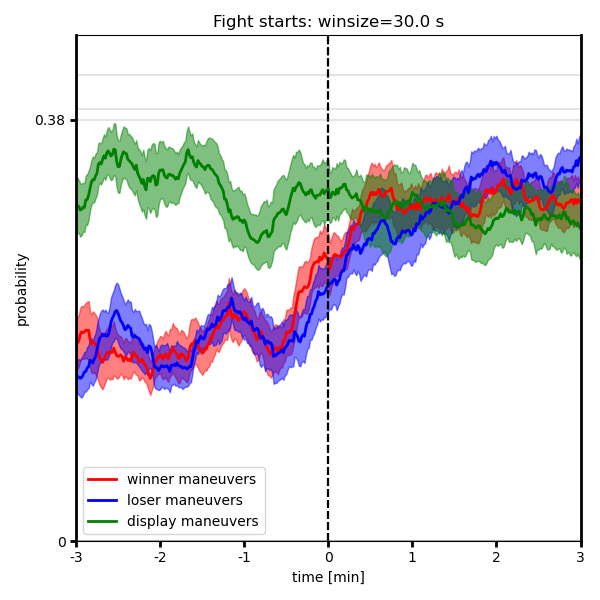

In [39]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
ax = axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# make colors for this
combined_colors = ['red', 'blue', 'green']

var_names = ['winner maneuvers', 'loser maneuvers', 'display maneuvers']


# plot the mean across trials
for stateIdx in [0,1,2]:
        
    # fill between the stdev lines
    max_curve = start_epoch_mean_win_state_probs[:, stateIdx] + start_epoch_stdevs[:, stateIdx]
    min_curve = start_epoch_mean_win_state_probs[:, stateIdx] - start_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, start_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=2,
           label=var_names[stateIdx])
    
    # xticks
    xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
    xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # set the yticks
    ax.set_yticks([0, states_y_tick_max[stateIdx]])
    ax.set_yticklabels([0, states_y_tick_max[stateIdx]])
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel('probability')
        
    # tick params
    ax.xaxis.set_tick_params(width=2, length=4)
    ax.yaxis.set_tick_params(width=2, length=4)
    
    # make the left and rights thicker for each axis
    for axis in ['left','right']:
        ax.spines[axis].set_linewidth(2)
        
    # # turn off all the interior x axes    
    # for ii in range(2):
    #     axs[ii].spines['bottom'].set_visible(False)
    #     axs[ii+1].spines['top'].set_visible(False)
        
    # set the gridlines
    #ax.grid(alpha=0.3)
    ax.axhline(y=0, color='grey', alpha=0.3)
    ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ax.legend()

    ax.set_title('Fight starts: winsize={0} s'.format(window_size/100))
    ax.set_xlabel('time [min]')
    
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
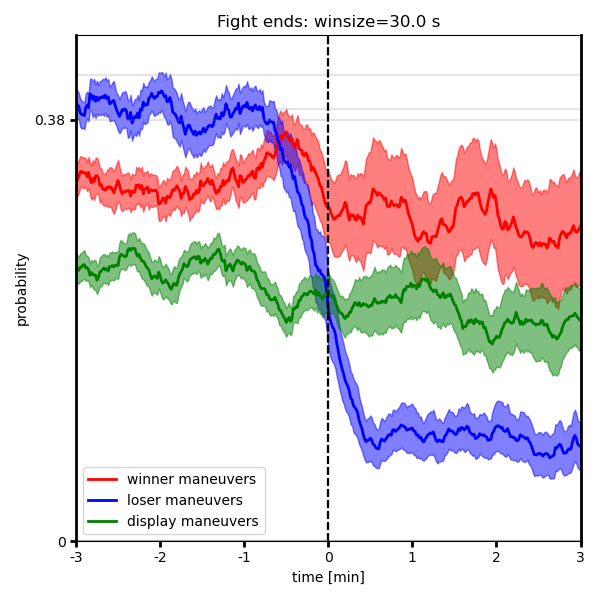

In [40]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
ax = axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# make colors for this
combined_colors = ['red', 'blue', 'green']

var_names = ['winner maneuvers', 'loser maneuvers', 'display maneuvers']


# plot the mean across trials
for stateIdx in [0,1,2]:
        
    # fill between the stdev lines
    max_curve = stop_epoch_mean_win_state_probs[:, stateIdx] + stop_epoch_stdevs[:, stateIdx]
    min_curve = stop_epoch_mean_win_state_probs[:, stateIdx] - stop_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, stop_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=2,
           label=var_names[stateIdx])
    
    # xticks
    xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
    xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # set the yticks
    ax.set_yticks([0, states_y_tick_max[stateIdx]])
    ax.set_yticklabels([0, states_y_tick_max[stateIdx]])
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel('probability')
        
    # tick params
    ax.xaxis.set_tick_params(width=2, length=4)
    ax.yaxis.set_tick_params(width=2, length=4)
    
    # make the left and rights thicker for each axis
    for axis in ['left','right']:
        ax.spines[axis].set_linewidth(2)
        
    # # turn off all the interior x axes    
    # for ii in range(2):
    #     axs[ii].spines['bottom'].set_visible(False)
    #     axs[ii+1].spines['top'].set_visible(False)
        
    # set the gridlines
    #ax.grid(alpha=0.3)
    ax.axhline(y=0, color='grey', alpha=0.3)
    ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ax.legend()
    
    ax.set_title('Fight ends: winsize={0} s'.format(window_size/100))
    ax.set_xlabel('time [min]')


fig.tight_layout()

## publication version plots - both panels at once

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
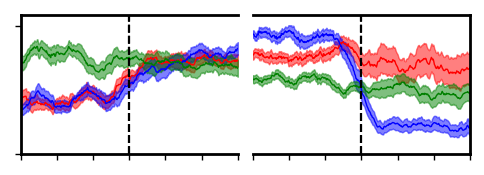

In [179]:
#imsavepath = '/home/liam/temp/image_transfer/figure7_A_v2.png'

fig = plt.figure(figsize=(4.85,1.75))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)
ax= axs[0]

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for axis in ['right']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = start_epoch_mean_win_state_probs[:, stateIdx] + start_epoch_stdevs[:, stateIdx]
    min_curve = start_epoch_mean_win_state_probs[:, stateIdx] - start_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, start_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=1)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=4)
    ax.yaxis.set_tick_params(width=1, length=4)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
#yticks = [0, states_y_tick_max[2], states_y_tick_max[3]]
#ax.set_yticks(yticks)

# set the yticks
ax.set_yticks([0, np.max(states_y_tick_max)])

#ax.set_yticks(yticks)
ax.set_yticklabels('')


# make the very top and very bottoms lines thicker
#ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
#ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)

    
    
    
    
    
# ---------------------------------------------------------------





ax= axs[1]
# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for axis in ['left']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = stop_epoch_mean_win_state_probs[:, stateIdx] + stop_epoch_stdevs[:, stateIdx]
    min_curve = stop_epoch_mean_win_state_probs[:, stateIdx] - stop_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, stop_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=1)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=4)
    ax.yaxis.set_tick_params(width=0, length=4)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
#yticks = [0, states_y_tick_max[2], states_y_tick_max[3]]
#ax.set_yticks(yticks)

# set the yticks
ax.set_yticks([0, np.max(states_y_tick_max)])
ax.set_yticklabels([0, states_y_tick_max[stateIdx]])

#ax.set_yticks(yticks)
ax.set_yticklabels('')


# make the very top and very bottoms lines thicker
#ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
#ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)
    
    
    
    
    
    



# ----------------------------#
fig.tight_layout()
#fig.savefig(imsavepath, dpi=300, transparent=False)

## publication version - split (Fig 7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
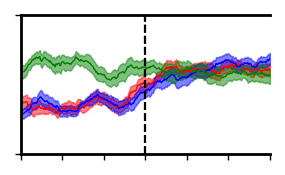

In [41]:
imsavepath = '/home/liam/temp/image_transfer/figure7_A_starts.png'

fig = plt.figure(figsize=(2.85,1.75))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)
ax= axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for axis in ['right']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = start_epoch_mean_win_state_probs[:, stateIdx] + start_epoch_stdevs[:, stateIdx]
    min_curve = start_epoch_mean_win_state_probs[:, stateIdx] - start_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, start_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=1)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    #ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=4)
    ax.yaxis.set_tick_params(width=1, length=4)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    


    
# ----------------------------------------------------#

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
#yticks = [0, states_y_tick_max[2], states_y_tick_max[3]]
#ax.set_yticks(yticks)

# set the yticks
ax.set_ylim(bottom=0, top=np.max(states_y_max))
ax.set_yticks([0, np.max(states_y_max)])

#ax.set_yticks(yticks)
ax.set_yticklabels('')


# make the very top and very bottoms lines thicker
#ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
#ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)




# ----------------------------#
fig.tight_layout()
fig.savefig(imsavepath, dpi=300, transparent=False)

In [42]:
np.max(states_y_tick_max)

0.42

In [43]:
states_y_tick_max

array([0.39, 0.42, 0.38])

In [44]:
states_y_max

array([0.468, 0.504, 0.456])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
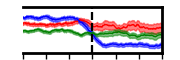

In [45]:
imsavepath = '/home/liam/temp/image_transfer/figure7_A_stops.png'

fig = plt.figure(figsize=(2.85,1.75))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)
ax= axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for axis in ['left']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = stop_epoch_mean_win_state_probs[:, stateIdx] + stop_epoch_stdevs[:, stateIdx]
    min_curve = stop_epoch_mean_win_state_probs[:, stateIdx] - stop_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, stop_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=1)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black', linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=4)
    ax.yaxis.set_tick_params(width=0, length=4)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    


    
# ----------------------------------------------------#

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
#yticks = [0, states_y_tick_max[2], states_y_tick_max[3]]
#ax.set_yticks(yticks)

# set the yticks
ax.set_ylim(bottom=0, top=np.max(states_y_max))
ax.set_yticks([0, np.max(states_y_max)])

#ax.set_yticks(yticks)
ax.set_yticklabels('')


# make the very top and very bottoms lines thicker
#ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
#ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)




# ----------------------------#
fig.tight_layout()
fig.savefig(imsavepath, dpi=300, transparent=False)

In [46]:
np.max(states_y_max)

0.504

## resized publication versions

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
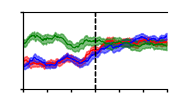

In [80]:
imsavepath = '/home/liam/temp/image_transfer/figure7_A_starts.png'

fig = plt.figure(figsize=(1.85, 1))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)
ax= axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(0.9)
    for axis in ['right']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = start_epoch_mean_win_state_probs[:, stateIdx] + start_epoch_stdevs[:, stateIdx]
    min_curve = start_epoch_mean_win_state_probs[:, stateIdx] - start_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, start_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=0.9)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), color='black',  linewidth=0.9, linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    #ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=1, length=2)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    


    
# ----------------------------------------------------#

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
#yticks = [0, states_y_tick_max[2], states_y_tick_max[3]]
#ax.set_yticks(yticks)

# set the yticks
ax.set_ylim(bottom=0, top=np.max(states_y_max))
ax.set_yticks([0, np.max(states_y_max)])

#ax.set_yticks(yticks)
ax.set_yticklabels('')

fig.savefig(imsavepath, dpi=1200, transparent=True)

In [62]:
np.max(states_y_tick_max)

0.42

In [63]:
states_y_tick_max

array([0.39, 0.42, 0.38])

In [64]:
states_y_max

array([0.468, 0.504, 0.456])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
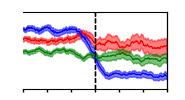

In [81]:
imsavepath = '/home/liam/temp/image_transfer/figure7_A_stops.png'

fig = plt.figure(figsize=(1.85, 1))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)
ax= axs

# create xvalues for plotting
x_vals_frames = np.array( [i*window_step for i in range(combined_numUsedWins)]) 


# plot the mean across trials
for stateIdx in [0,1,2]:
    
    # make the left and rights thicker for each axis
    #for axis in ['left','right']:
    for axis in ['left', 'right']:
        ax.spines[axis].set_linewidth(0.9)
    for axis in ['left']:
        ax.spines[axis].set_visible(False)
    
    # fill between the stdev lines
    max_curve = stop_epoch_mean_win_state_probs[:, stateIdx] + stop_epoch_stdevs[:, stateIdx]
    min_curve = stop_epoch_mean_win_state_probs[:, stateIdx] - stop_epoch_stdevs[:, stateIdx]
    ax.fill_between(x_vals_frames, y1=min_curve, y2=max_curve, color=combined_colors[stateIdx], alpha=0.5)

    # plot the mean
    ax.plot(x_vals_frames, stop_epoch_mean_win_state_probs[:, stateIdx], color=combined_colors[stateIdx], linewidth=0.9)
    
    # xticks
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    
    # plot the dividing line between epochs
    ax.axvline(np.mean(x_vals_frames), linewidth=0.9, color='black', linestyle='--')
    
    # plot limits
    ax.set_xlim(x_vals_frames[0], x_vals_frames[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
     # axes labels
    ax.set_ylabel(all_state_names[stateIdx]+'\n prob')
        
    # tick params
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=0, length=2)

    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
    
    ## EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    


    
# ----------------------------------------------------#

# xticks
xticks = np.array([i*6000 for i in range(int(total_plot_time_mins*2)+1)]) #*2 because of concatenated 2 epochs
xticklabels = [i for i in range(-total_plot_time_mins, total_plot_time_mins+1)]
ax.set_xticks(xticks);

# set the yticks
ax.set_ylim(bottom=0, top=np.max(states_y_max))
ax.set_yticks([0, np.max(states_y_max)])

#ax.set_yticks(yticks)
ax.set_yticklabels('')

fig.savefig(imsavepath, dpi=1200, transparent=True)

In [66]:
np.max(states_y_max)

0.504